In [1]:
using NamedArrays, JuMP

INFO: Recompiling stale cache file /Users/spidy/.julia/lib/v0.5/NamedArrays.ji for module NamedArrays.


# Solution 1 - Doodle scheduling. 
Doodle Inc. is looking to interview a candidate for a new software engineer position at their company. It works like this: the interview (10 AM to 3 PM) is divided into a number of 20-minute time slots that may be used for 1-on-1 meetings with the candidate. There is also a one-hour time slot in the middle of the day where 3 employees take the candidate out for lunch. It would be nice for all 15 senior employees to meet with the candidate at some point during the day, but everybody has a busy schedule so it’s not clear whether this will be possible. A doodle poll (obviously) was sent to the 15 senior employees to figure out their availability.

In [2]:
# Given Input (Thanks to Piazza post for giving the idea on how to print and use input data from the question)
employees = [:Manuel, :Luca, :Jule, :Michael, :Malte, :Chris, :Spyros, :Mirjam,
    :Matt, :Florian, :Josep, :Joel, :Tom, :Daniel, :Anne]

times = ["10:00", "10:20", "10:40", "11:00", "11:20", "11:40", "Lunch", "1:00", "1:20", "1:40", "2:00", "2:20", "2:40"]

matrix = [
0	0	1	1	0	0	0	1	1	0	0	0	0
0	1	1	0	0	0	0	0	1	1	0	0	0
0	0	0	1	1	0	1	1	0	1	1	1	1
0	0	0	1	1	1	1	1	1	1	1	1	0
0	0	0	0	0	0	1	1	1	0	0	0	0
0	1	1	0	0	0	0	0	1	1	0	0	0
0	0	0	1	1	1	1	0	0	0	0	0	0
1	1	0	0	0	0	0	0	0	0	1	1	1
1	1	1	0	0	0	0	0	0	1	1	0	0
0	0	0	0	0	0	0	1	1	0	0	0	0
0	0	0	0	0	0	1	1	1	0	0	0	0
1	1	0	0	0	1	1	1	1	0	0	1	1
1	1	1	0	1	1	0	0	0	0	0	1	1
0	1	1	1	0	0	0	0	0	0	0	0	0
1	1	0	0	1	1	0	0	0	0	0	0	0
]

using NamedArrays
data = NamedArray(matrix, (employees, times), ("employees","time"))
show(IOContext(STDOUT, displaysize=(100, 1000)), data)

15×13 Named Array{Int64,2}
employees ╲ time │ 10:00  10:20  10:40  11:00  11:20  11:40  Lunch   1:00   1:20   1:40   2:00   2:20   2:40
─────────────────┼──────────────────────────────────────────────────────────────────────────────────────────
Manuel           │     0      0      1      1      0      0      0      1      1      0      0      0      0
Luca             │     0      1      1      0      0      0      0      0      1      1      0      0      0
Jule             │     0      0      0      1      1      0      1      1      0      1      1      1      1
Michael          │     0      0      0      1      1      1      1      1      1      1      1      1      0
Malte            │     0      0      0      0      0      0      1      1      1      0      0      0      0
Chris            │     0      1      1      0      0      0      0      0      1      1      0      0      0
Spyros           │     0      0      0      1      1      1      1      0      0      0      0      0

In [3]:
# From the input question - each employee will interview the candidate only once and so for all employees the 
# supply will be equal to 1
supply = Dict(zip( employees, [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] ))

# From the input question - for each interval, candidate will interview with just one person at each time slot. 
# For lunch however, three employees should be present. Hence, the demand for lunch will be 3 and rest all will be 1.
demand = Dict(zip( times, [1 1 1 1 1 1 3 1 1 1 1 1 1] ));

In [4]:
m1 = Model()

# Decision variables x[i,j] >= 0
@variable(m1, x[employees,times] >= 0)

# supply constraint
@constraint(m1, sup[i in employees], sum(x[i,j] for j in times) == supply[i] )
# demand constraint
@constraint(m1, dem[j in times], sum(x[i,j] for i in employees) == demand[j] )

# constraint that employees should be available during the timeslot (as per given input 0 means not available and 
# 1 means available)
for i in employees
    for j in times
        @constraint(m1, x[i, j] <= data[i, j])
    end
end

# Objective
@objective(m1, Min, sum( x[i,j] for i in employees, j in times ) );

In [5]:
status = solve(m1)

println(status)

# nicely formatted solution
solution = NamedArray( Int[getvalue(x[i,j]) for i in employees, j in times], (employees,times), ("People","Time_Slot") )

println()
println("Solution is feasible. Calendar for the candidate that lists who they will be meeting at each time slot")
println()
show(IOContext(STDOUT, displaysize=(100, 1000)), solution)
println()
println("Total: ", getobjectivevalue(m1))

Optimal

Solution is feasible. Calendar for the candidate that lists who they will be meeting at each time slot

15×13 Named Array{Int64,2}
People ╲ Time_Slot │ 10:00  10:20  10:40  11:00  11:20  11:40  Lunch   1:00   1:20   1:40   2:00   2:20   2:40
───────────────────┼──────────────────────────────────────────────────────────────────────────────────────────
Manuel             │     0      0      0      0      0      0      0      1      0      0      0      0      0
Luca               │     0      0      0      0      0      0      0      0      0      1      0      0      0
Jule               │     0      0      0      0      0      0      0      0      0      0      0      1      0
Michael            │     0      0      0      0      0      0      0      0      0      0      1      0      0
Malte              │     0      0      0      0      0      0      1      0      0      0      0      0      0
Chris              │     0      0      1      0      0      0      0      0      0 

# Solution 2 - Car rental.
A small car rental company has a fleet of 94 vehicles distributed among its 10 agencies. The location of every agency is given by its geographical coordinates x and y in a grid based on miles. We assume that the road distance between agencies is approximately 1.3 times the Euclidean distance (as the crow flies). The following table indicates the coordinates of all agencies, the number of cars required the next morning, and the stock of cars in the evening preceding this day.

In [19]:
# Given input data
agencies = [1:10;]
matrix = [
0 20 18 30 35 33 5 5 11 2
0 20 10 12 0 25 27 10 0 15
10 6 8 11 9 7 15 7 9 12
8 13 4 8 12 2 14 11 15 7
]
properties = [:xCoords, :yCoords, :carsReq, :carsPres]

using NamedArrays
data = NamedArray(matrix, (properties, agencies), ("Property", "Agency"))

4×10 Named Array{Int64,2}
Property ╲ Agency │  1   2   3   4   5   6   7   8   9  10
──────────────────┼───────────────────────────────────────
xCoords           │  0  20  18  30  35  33   5   5  11   2
yCoords           │  0  20  10  12   0  25  27  10   0  15
carsReq           │ 10   6   8  11   9   7  15   7   9  12
carsPres          │  8  13   4   8  12   2  14  11  15   7

In [20]:
# Cost
cost = 0.5

# Agencies with excess cars (i.e. carsPres > carsReq)
excess_cars_agencies = [2, 5, 8, 9]

# Agencies with less cars (i.e. carsPres < carsReq)
less_cars_agencies = [:1, :3, :4, :6, :7, :10]

# Input coordinates for all the agencies
x = [0, 20, 18, 30, 35, 33, 5, 5, 11, 2]
y = [0, 20, 10, 12, 0, 25, 27, 10, 0, 15]

# Agencies that have excess cars with them - calculate the # of excess cars and save the difference. For ex. Agency 2
# has 13 cars present and 6 are required. Excess cars = 13 - 6 = 7. Similarly calculate for all excess car agencies
supply = Dict(zip( excess_cars_agencies, [7 3 4 6] ))

# Agencies that require car - For ex. Agency 1 has 8 cars but need 10. So, we will save the difference as 2. Therefore
# Agency 1 needs 2 cars. Similarly calculated for other agencies requiring car. 
demand = Dict(zip( less_cars_agencies, [2 4 3 5 1 5] ));

In [21]:
# Function to calculate distance between the agencies where transferred is required. This function will store the dist
# value based on the given input conditions into a list which will be used to populate the multidimensional distance
# matrix. 
di = []
for i in excess_cars_agencies
    x_a = x[i]
    y_a = y[i]
    for j in less_cars_agencies
        x_b = x[j]
        y_b = y[j]
        dist_a_b = 1.3*sqrt((x_a - x_b)^2 + (y_a - y_b)^2)
        push!(di, dist_a_b)
    end
end 

# Multi-dimensional matrix (4 because we have 4 agencies with excess car and 6 columns as we have 6 agencies that need
# car at their locations.)
mat = [0.0 for i=1:4, j=1:6]

k = 0
for i=1:size(mat,1)
    k += 1
    for j=1:6
        mat[i,j] = di[k]
        k += 1
    end
    k -= 1
end
# Putting the distance values in dist NamedArray
dist = NamedArray( [36.7696 13.2575 16.6481 18.1069 21.5188 24.286; 45.5 25.64 16.9 32.6038 52.4691 47.1239; 14.5344 16.9 32.6038 41.2942 22.1 7.58024; 14.3 15.8685 29.2139 43.2921 35.9562 22.7407], (excess_cars_agencies,less_cars_agencies), ("Agencies(ExtraCars)","Agencies(NeedCar)") )

println("Distance Matrix between agencies (with extra cars and the one which need cars)")
println()
show(IOContext(STDOUT, displaysize=(100, 1000)), dist)

Distance Matrix between agencies (with extra cars and the one which need cars)

4×6 Named Array{Float64,2}
Agencies(ExtraCars) ╲ Agencies(NeedCar) │       1        3        4        6        7       10
────────────────────────────────────────┼─────────────────────────────────────────────────────
2                                       │ 36.7696  13.2575  16.6481  18.1069  21.5188   24.286
5                                       │    45.5    25.64     16.9  32.6038  52.4691  47.1239
8                                       │ 14.5344     16.9  32.6038  41.2942     22.1  7.58024
9                                       │    14.3  15.8685  29.2139  43.2921  35.9562  22.7407

In [22]:
m2 = Model()
@variable(m2, x[excess_cars_agencies,less_cars_agencies] >= 0)
@constraint(m2, sup[i in excess_cars_agencies], sum(x[i,j] for j in less_cars_agencies) == supply[i] )
@constraint(m2, dem[j in less_cars_agencies], sum(x[i,j] for i in excess_cars_agencies) == demand[j] )
@objective(m2, Min, cost*sum( x[i,j]*dist[i,j] for i in excess_cars_agencies, j in less_cars_agencies ) )
                                    
status = solve(m2)

println(status)

# nicely formatted solution
solution = NamedArray( Int[getvalue(x[i,j]) for i in excess_cars_agencies, j in less_cars_agencies], (excess_cars_agencies,less_cars_agencies), ("excess_cars_agencies","less_cars_agencies") )
println( solution )
println()

println("Total cost will be \$", getobjectivevalue(m2))

Optimal
4×6 Named Array{Int64,2}
excess_cars_agencies ╲ less_cars_agencies │  1   3   4   6   7  10
──────────────────────────────────────────┼───────────────────────
2                                         │  0   1   0   5   1   0
5                                         │  0   0   3   0   0   0
8                                         │  0   0   0   0   0   4
9                                         │  2   3   0   0   0   1

Total cost will be $152.63897999999998


# Solution 3: Building a stadium.
A town council wishes to construct a small stadium in order to improve the services provided to the people living in the district. After the invitation to tender, a local construction company is awarded the contract and wishes to complete the task within the shortest possible time. All the major tasks are listed in the following table. Some tasks can only start after the completion of certain other tasks, as indicated by the “Predecessors” column.

In [2]:
# I am adding one extra task - 19 that will just signify the Finish of the project. Task 19 will have a duration of 0.
# Task 19 will have arc from Task 10, 13, 15, 16 and 18.
# Based on this I have add duration of 0, preds of Task 19 as 10, 13, 15, 16 and 18

tasks = [1:19;]

duration  = Dict(zip(tasks, [2, 16, 9, 8, 10, 6, 2, 2, 9, 5, 3, 2, 1, 7, 4, 3, 9, 1, 0]))
preds     = Dict(zip(tasks, ([],[1],[2],[2],[3],[4,5],[4],[6],[4,6],[4],[6],[9],[7],[2],[4,14],[8,11,14],[12],[17], [10,13,15,16,18])))
maxReduc  = Dict(zip(tasks, [0, 3, 1, 2, 2, 1, 1, 0, 2, 1, 1, 0, 0, 2, 2, 1, 3, 0, 0]))
reducCost = Dict(zip([2, 3, 4, 5, 6, 7, 9, 10, 11, 14, 15, 16, 17], [30, 26, 12, 17, 15, 8, 42, 21, 18, 22, 12, 6, 16]));

What is the earliest possible date of completion for the construction? Note that the last two columns of the table are not relevant for this part of the problem.

<b><u>Solution 3a</u></b> - Please find the solution below. The start variable should be >=0 for all the task ids in the list. 
Adding constraint where task with predecessors can only start when the previous task is finished. For example if there is an arc between i and j - this means there is a dependency that task j can start only when task i has finished with duration.

In [5]:
m3a = Model()

@variable(m3a, tstart[tasks] >= 0 )
for i in tasks
    for j in preds[i]
        @constraint(m3a, tstart[i] >= tstart[j] + duration[j])
    end
end
@objective(m3a, Min, tstart[19])

# solve(m3a)
# println(getvalue(tstart))

# println("Earliest possible date of completion for the construction (in weeks): ", getobjectivevalue(m3a))

tstart[19]

In [6]:
m3a

Minimization problem with:
 * 27 linear constraints
 * 19 variables
Solver is default solver

<b><u>Solution 3b</u></b>  Plot a trade-off curve that shows extra cost as a function of the number of weeks
early we wish the stadium to be completed.

In [12]:
function f3b(extra_weeks)
    m3b = Model()

    rCost = Dict(zip(tasks, [0, 30, 26, 12, 17, 15, 8, 0, 42, 21, 18, 0, 0, 22, 12, 6, 16, 0, 0]));

    # Decision variable for number of weeks finished before allotted period
    @variable(m3b, treduc[tasks] >= 0 )

    # Decision variable for start time of each task
    @variable(m3b, tstart[tasks] >= 0 )

    # Constrainst as per input table that the number of weeks finished early can not be greater than max reduction
    for i in 1:18
        @constraint(m3b, treduc[i] <= maxReduc[i])
    end

    # Using solution 3a answer here (64 weeks). The new start time for task 19 + saved time should be equal to 64 weeks - 
    # extra weeks (Varying it from 1 - 13). For 13 you will see an infeasible solution
    @constraint(m3b, tstart[19] + treduc[19] == getobjectivevalue(m3a) - extra_weeks)

    # Considering there is an arc from i to j - then adding Constraint that start time for task j should be greater than
    # start time of task i + its duration - whatever time we have saved
    for i in tasks
        for j in preds[i]
            @constraint(m3b, tstart[i] - tstart[j] + treduc[j] >= duration[j])
        end
    end

    # Objective function is to maximize the profit which will be 30K * saved time at the end - sum of (cost of reduction 
    # incurred for task i * reduction in time for task i)
    @objective(m3b, Min, sum(treduc[i] * rCost[i] for i in tasks))

    solve(m3b)
    # println(getvalue(tstart))
    println("Extra Cost for each additional week (in thousand dollars): ", getobjectivevalue(m3b))
end

for i in 0:13
    f3b(i)
end

Extra Cost for each additional week (in thousand dollars): 0.0
Extra Cost for each additional week (in thousand dollars): 15.0
Extra Cost for each additional week (in thousand dollars): 31.0
Extra Cost for each additional week (in thousand dollars): 47.0
Extra Cost for each additional week (in thousand dollars): 63.0
Extra Cost for each additional week (in thousand dollars): 80.0
Extra Cost for each additional week (in thousand dollars): 97.0
Extra Cost for each additional week (in thousand dollars): 123.0
Extra Cost for each additional week (in thousand dollars): 153.0
Extra Cost for each additional week (in thousand dollars): 183.0
Extra Cost for each additional week (in thousand dollars): 213.0
Extra Cost for each additional week (in thousand dollars): 255.0
Extra Cost for each additional week (in thousand dollars): 297.0
Extra Cost for each additional week (in thousand dollars): NaN


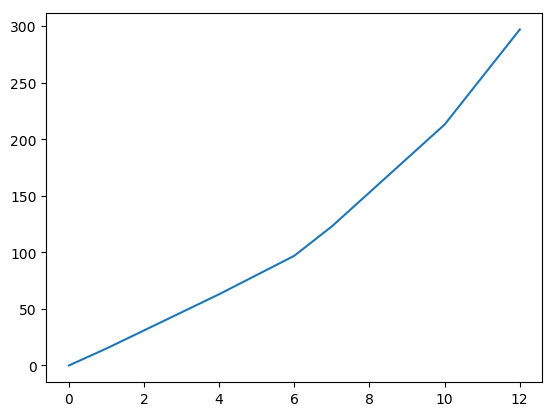

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31e630c10>

In [13]:
extra_cost=[0, 15, 31, 47, 63, 80, 97, 123, 153, 183, 213, 255, 297]
reduced_time=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
using PyPlot
plot(reduced_time,extra_cost,label="extra cost vs reduced weeks")

<b><u>Solution 3c</u></b> - The town council wants the builder to expedite the project. As an incentive, the council will pay a bonus of $30k/week for each week the work finishes early. When will the project be completed if the builder is acting in a way that maximizes his profit?

In [14]:
rCost = Dict(zip(tasks, [0, 30, 26, 12, 17, 15, 8, 0, 42, 21, 18, 0, 0, 22, 12, 6, 16, 0, 0]));

In [15]:
m3c = Model()

# Decision variable for number of weeks finished before allotted period
@variable(m3c, treduc[tasks] >= 0 )

# Decision variable for start time of each task
@variable(m3c, tstart[tasks] >= 0 )

# Constrainst as per input table that the number of weeks finished early can not be greater than max reduction
for i in 1:18
    @constraint(m3c, treduc[i] <= maxReduc[i])
end

# Using solution 3a answer here (64 weeks). The new start time for task 19 + saved time should be equal to 64 weeks
@constraint(m3c, tstart[19] + treduc[19] == getobjectivevalue(m3a))

# Considering there is an arc from i to j - then adding Constraint that start time for task j should be greater than
# start time of task i + its duration - whatever time we have saved
for i in tasks
    for j in preds[i]
        @constraint(m3c, tstart[i] - tstart[j] + treduc[j] >= duration[j])
    end
end

# Objective function is to maximize the profit which will be 30K * saved time at the end - sum of (cost of reduction 
# incurred for task i * reduction in time for task i)
@objective(m3c, Max, (30*treduc[19]) - sum(treduc[i] * rCost[i] for i in tasks))
            
solve(m3c)
println(getvalue(treduc))
println(getvalue(tstart))
println("Maximum Profit (in thousand dollars): ", getobjectivevalue(m3c))
println("Job will be finished 10 weeks earlier!!")

treduc: 1 dimensions:
[ 1] = 0.0
[ 2] = 3.0
[ 3] = 1.0
[ 4] = 0.0
[ 5] = 2.0
[ 6] = 1.0
[ 7] = 0.0
[ 8] = 0.0
[ 9] = 0.0
[10] = 0.0
[11] = 0.0
[12] = 0.0
[13] = 0.0
[14] = 0.0
[15] = 0.0
[16] = 0.0
[17] = 3.0
[18] = 0.0
[19] = 10.0

tstart: 1 dimensions:
[ 1] = 0.0
[ 2] = 2.0
[ 3] = 15.0
[ 4] = 15.0
[ 5] = 23.0
[ 6] = 31.0
[ 7] = 51.0
[ 8] = 49.0
[ 9] = 36.0
[10] = 49.0
[11] = 48.0
[12] = 45.0
[13] = 53.0
[14] = 15.0
[15] = 50.0
[16] = 51.0
[17] = 47.0
[18] = 53.0
[19] = 54.0

Maximum Profit (in thousand dollars): 87.0
Job will be finished 10 weeks earlier!!


# Solution 4 - Dual interpretation

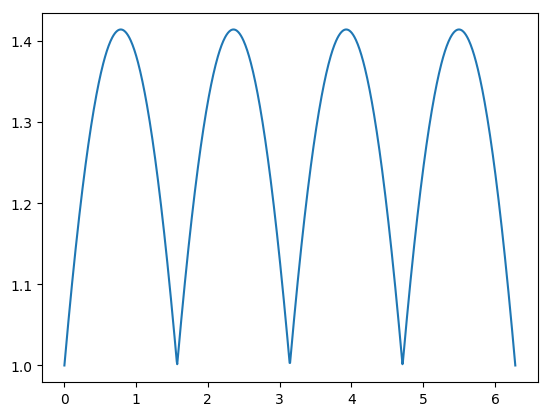

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x321c720d0>

In [16]:
val = linspace(0, 2π, 1000)
func_val = []
function f(t)
    m4a = Model()
    @variable(m4a, p >= 0)
    @variable(m4a, q >= 0)
    @variable(m4a, r >= 0)
    @variable(m4a, s >= 0)
    @constraint(m4a, p - r == cos(t))
    @constraint(m4a, q - s == sin(t))
    @objective(m4a, Min, p + q + r + s)
    status=solve(m4a)
    push!(func_val, getobjectivevalue(m4a))
end

for i in 1:1000
    f(val[i])
end

using PyPlot
plot(val, func_val, label="f(t) vs t")

<b><u>Understanding: </u></b>Looking at the above plotting, it looks like the graph is always plotted on the positive side. First curve comes down to π/2, second from π/2 to π, third from π/2 to 3π/2 and 4th curve from 3π/2 to 2π. So, let's consider all the possible cases:
<br>
1. if cost(t) < 0: this means from p - r = cos(t), p = 0 and r = -cos(t)
<br>
2. if cost(t) > 0: this means from p - r = cos(t), r = 0 and p = cos(t)
<br>
3. if sin(t) < 0: this means from q - s = sin(t), q = 0 and s = -sin(t)
<br>
4. if sin(t) > 0: this means from q - s = sin(t), s = 0 and q = -sin(t)

Like four quadrant of the circle we will have 1st quadrant (sin(t) and cos(t) positive), 2nd quadrant (sin(t) positive and cos(t) negative, 3rd quadrant (both sin(t) and cos(t) negative) and 4th quadrant (cos(t) positive and sin(t) negative).

Looking at this it seems like p+q+r+s = |sin(t)| + |cos(t)| is what can be interpreted from the plot and understanding above.

<b><u>Solution 4b: </u></b> Find the dual LP and interpret it geometrically. Does this agree with the solution of part a)?
Looking at the example discussed in class where the primal problem is converted to dual problem.

Let λ1, λ2 be the multipliers.
<br>
p + q + r + s >= λ1(p-r) + λ2(q-s)
<br>
p + q + r + s >= λ1(cos(t)) + λ2(sin(t)) ------------------------------- (1)
<br>
<br>
Rearranging (1) we get
<br>
λ1p - λ1r + λ2q - λ2s - p - q - r - s <= 0
<br>
p(λ1-1) + q(λ2-1) + r(-λ1-1) + s(-λ2-s) <= 0 --------------------------- (2)

<br>
<b>Dual Problem:</b>
<br>
\begin{equation*}
maximize_{λ1, λ2}: λ1(cos(t)) + λ2(sin(t))
\end{equation*}
\begin{equation*}
subject to: λ1 <= 1
\end{equation*}
\begin{equation*}
λ2 <= 1
\end{equation*}
\begin{equation*}
λ1 >= -1
\end{equation*}
\begin{equation*}
λ2 >= -1
\end{equation*}

<br>
λ1 and λ2 are free variables so we will just declare them variables.

A = 
$\left[ \begin{array}{cccc}
1 & 0\\
0 & 1\\
-1 & 0\\
0 & -1\\\end{array} \right]$    b = 
$\left[ \begin{array}{cccc}
λ1\\
λ2\\ \end{array} \right]$     c = 
$\left[ \begin{array}{cccc}
1\\
1\\
1\\
1\\\end{array} \right]$

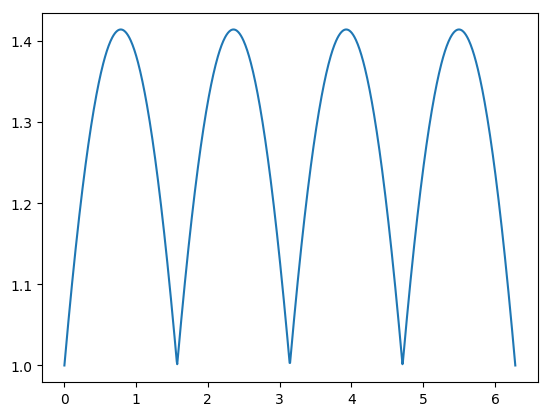

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x321e259d0>

In [17]:
val = linspace(0, 2π, 1000)
func_val = []
function f1(t)
    m4b = Model()
    @variable(m4b, λ[1:2])
    @constraint(m4b, λ[1] <= 1)
    @constraint(m4b, λ[2] <= 1)
    @constraint(m4b, λ[1] >= -1)
    @constraint(m4b, λ[2] >= -1)

    @objective(m4b, Max, λ[1]*cos(t) + λ[2]*sin(t))

    status = solve(m4b)
    push!(func_val, getobjectivevalue(m4b))
end

for i in 1:1000
    f1(val[i])
end

using PyPlot
plot(val, func_val, label="f1(t) vs t")